In [310]:
import os
os.system ("pip install xgboost")
os.system ("pip install boruta")
os.system ("pip install lightgbm")

import pandas as pd
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


# Notebook style properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style> .output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 300%;}</style>"))

# Matplotlib parameters
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [12, 8] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

In [246]:
df = pd.read_csv("final.csv",sep=",")

In [247]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.drop('win_by', inplace=True, axis=1)

In [646]:
df.head()

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R,Winner_num
0,2,7,10,7,19,0.70,0.36,7,10,9,...,NaN,NaN,182.88,155.0,75.0,19154,6,30.07,NaN,0
1,0,18,51,47,89,0.35,0.52,19,52,47,...,170.0,74.0,180.34,170.0,73.0,19154,6,27.83,28.20,1
2,0,45,74,33,55,0.60,0.60,89,122,66,...,185.0,75.0,175.26,185.0,73.0,19154,6,26.81,26.47,0
3,1,69,102,43,85,0.67,0.50,94,130,44,...,115.0,63.0,167.64,115.0,65.0,19154,6,34.84,32.85,0
4,0,46,163,51,111,0.28,0.45,64,184,69,...,145.0,74.0,177.80,145.0,73.0,19154,6,28.07,30.25,1


In [252]:
df['Winner_num'] = df.Winner.map({'Red':0,'Blue':1,'Draw':2})
df=df.drop(columns=['Winner'],axis=1)

In [254]:
X = df.drop(['Winner_num'], axis=1)
y = df['Winner_num']

In [202]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, shuffle=False)

In [83]:
#Mode for Stance
mode_imp=SimpleImputer(strategy='most_frequent')
mode_columns=['B_Stance','R_Stance']
X_train[mode_columns]=mode_imp.fit_transform(X_train[mode_columns])
X_test[mode_columns]=mode_imp.transform(X_test[mode_columns])

In [84]:
#Mean for every other numerical category
mean_cols=[colname for colname in X_train.columns if X_train[colname].dtype in ['int64','float64']]

mean_imp=SimpleImputer(strategy='mean')
X_train[mean_cols]=mean_imp.fit_transform(X_train[mean_cols])
X_test[mean_cols]=mean_imp.transform(X_test[mean_cols])

In [85]:
#find categorical columns
cat_cols=[col for col in X_train.columns if X_train[col].dtype=='object']

different_columns=[]

In [86]:
#Let's make a list of columns whose contained values differ from training to testing set
for col in cat_cols:
    if set(X_train[col])!= set(X_test[col]):
        different_columns.append(col)
print(different_columns)
print(cat_cols)
#Drop different columns
X_train=X_train.drop(columns=different_columns, axis=1)
X_test=X_test.drop(columns=different_columns,axis=1)

['R_fighter', 'B_fighter', 'R_CTRL', 'B_CTRL', 'last_round_time', 'Referee', 'location', 'Fight_type', 'R_Stance', 'B_Stance']
['R_fighter', 'B_fighter', 'R_CTRL', 'B_CTRL', 'last_round_time', 'Referee', 'location', 'Fight_type', 'R_Stance', 'B_Stance']


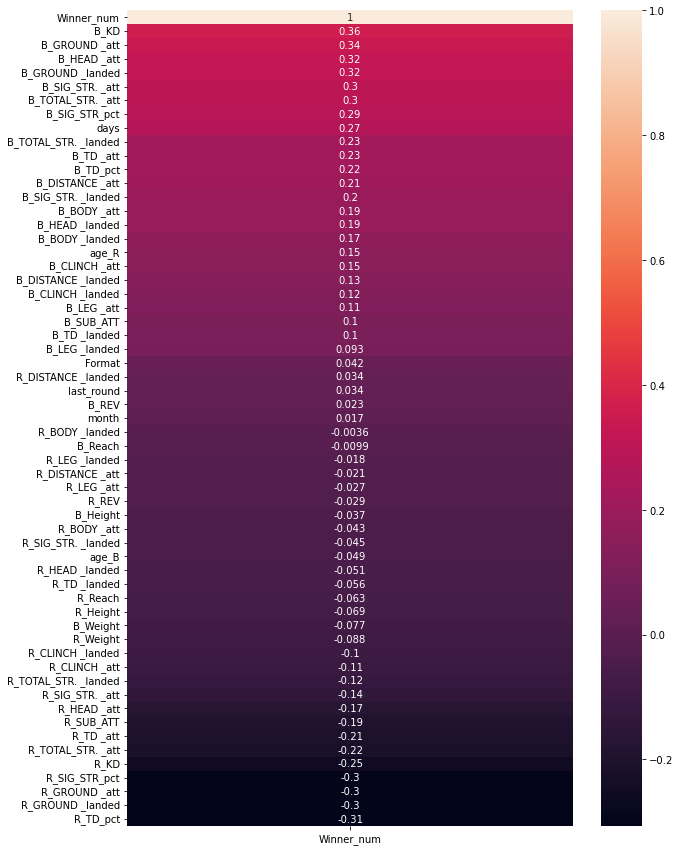

In [87]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['Winner_num']].sort_values(by='Winner_num', ascending=False),annot=True)
plt.show()

In [88]:
scaler=StandardScaler();
numerical_cols=[colname for colname in X_train.columns if X_train[colname].dtype in ['int64','float64']];
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols]);
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols]);

In [89]:
model = XGBClassifier()
X_train=X_train.loc[y_train!=2,:]
y_train=y_train[y_train!=2]
X_test=X_test.loc[y_test!=2]
y_test=y_test[y_test!=2]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4969, 58)
(4969,)
(1657, 58)
(1657,)


In [90]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [92]:
pred = model.predict(X_test)

In [93]:
Score = model.score(X_test,y_test)
print("Score: %.2f%%" % (Score * 100.0))

Score: 87.99%


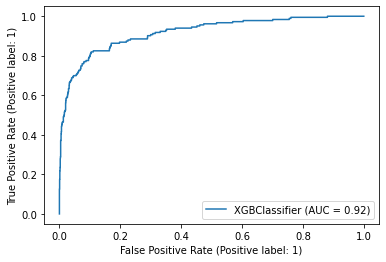

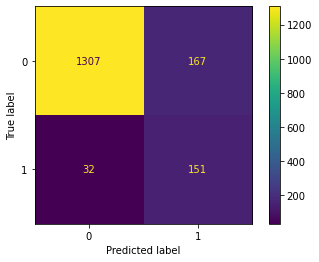

In [94]:
plot_roc_curve(model,X_test,y_test)
plot_confusion_matrix(model,X_test,y_test)

In [257]:
df2 = df

cols =df2.columns

In [262]:
df2.drop('R_fighter', inplace=True, axis=1)
df2.drop('B_fighter', inplace=True, axis=1)
df2.drop('last_round_time', inplace=True, axis=1)
df2.drop('B_KD', inplace=True, axis=1)
df2.drop('R_CTRL', inplace=True, axis=1)
df2.drop('B_CTRL', inplace=True, axis=1)
df2.drop('Referee', inplace=True, axis=1)
df2.drop('location', inplace=True, axis=1)
df2.drop('Fight_type', inplace=True, axis=1)
df2.drop('R_Stance', inplace=True, axis=1)
df2.drop('B_Stance', inplace=True, axis=1)

In [279]:
target_label = 'Winner_num'
columns = [col for col in df2.columns if col not in target_label]
cats = [col for col in columns if df2[col].dtype == 'object']
nums = [col for col in columns if df2[col].dtype != 'object']

X = df2[columns].copy()
y = df2[target_label].copy()
X.shape, y.shape

((6626, 57), (6626,))

In [280]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), test_size=0.25, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4969, 57), (1657, 57), (4969,), (1657,))

In [263]:
scaler = MinMaxScaler()


## EN ADTAM EZT HOZZA ## EN ADTAM EZT HOZZA ## EN ADTAM EZT HOZZA
# create an object for KNNImputer
imputer = KNNImputer(n_neighbors=2)
halo = imputer.fit_transform(df2)


df2 = pd.DataFrame(halo, columns =cols)

In [281]:
scaler.fit(X_train[nums])
X_train_scaled = scaler.transform(X_train[nums])
X_train[nums] = X_train_scaled
X_train.head()

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Height,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R
2900,0.2,0.031461,0.026882,0.078603,0.062626,0.70,0.58,0.067114,0.049598,0.056338,...,0.521739,0.391304,0.625000,0.695652,0.245614,0.708333,0.772388,0.545455,0.821842,0.815630
5971,0.2,0.029213,0.047043,0.043668,0.056566,0.37,0.35,0.029083,0.046917,0.042254,...,0.521739,0.391304,0.625000,0.434783,0.245614,0.645833,0.437700,0.000000,0.848388,0.825134
5646,0.0,0.000000,0.000000,0.004367,0.004040,0.25,0.50,0.008949,0.005362,0.002817,...,0.565217,0.304348,0.750000,0.521739,0.245614,0.500000,0.499564,0.818182,0.857919,0.825310
1747,0.0,0.017978,0.021505,0.021834,0.050505,0.50,0.20,0.017897,0.021448,0.014085,...,0.434783,0.239130,0.458333,0.608696,0.192982,0.625000,0.857392,1.000000,0.854356,0.869577
4244,0.4,0.087640,0.083333,0.039301,0.034343,0.62,0.52,0.127517,0.108579,0.152113,...,0.521739,0.304348,0.708333,0.608696,0.245614,0.645833,0.671411,0.727273,0.861126,0.854792


In [282]:
df2

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R,Winner_num
0,2.0,7.0,10.0,7.0,19.0,0.70,0.36,7.0,10.0,9.0,...,130.0,72.0,182.88,155.0,75.0,19154.0,6.0,30.070,29.870,0.0
1,0.0,18.0,51.0,47.0,89.0,0.35,0.52,19.0,52.0,47.0,...,170.0,74.0,180.34,170.0,73.0,19154.0,6.0,27.830,28.200,1.0
2,0.0,45.0,74.0,33.0,55.0,0.60,0.60,89.0,122.0,66.0,...,185.0,75.0,175.26,185.0,73.0,19154.0,6.0,26.810,26.470,0.0
3,1.0,69.0,102.0,43.0,85.0,0.67,0.50,94.0,130.0,44.0,...,115.0,63.0,167.64,115.0,65.0,19154.0,6.0,34.840,32.850,0.0
4,0.0,46.0,163.0,51.0,111.0,0.28,0.45,64.0,184.0,69.0,...,145.0,74.0,177.80,145.0,73.0,19154.0,6.0,28.070,30.250,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,0.0,1.0,1.0,1.0,1.0,1.00,1.00,1.0,1.0,2.0,...,225.0,72.0,186.69,192.5,73.0,9088.0,11.0,21.525,31.250,0.0
6622,0.0,8.0,12.0,2.0,6.0,0.66,0.33,11.0,15.0,2.0,...,170.0,72.0,187.96,245.0,73.0,9088.0,11.0,24.710,26.650,0.0
6623,0.0,2.0,3.0,0.0,0.0,0.66,0.72,14.0,15.0,0.0,...,225.0,72.0,190.50,210.0,73.0,9088.0,11.0,22.155,31.250,0.0
6624,0.0,11.0,17.0,4.0,5.0,0.64,0.80,74.0,86.0,95.0,...,210.0,72.0,195.58,275.0,73.0,9088.0,11.0,24.760,26.160,0.0


In [283]:
onehotcats = [col for col in cats]
ohe = OneHotEncoder(drop='first', sparse=False).fit(X_train[onehotcats])
ohe.get_feature_names(onehotcats)

array([], dtype=object)

In [284]:
X_train_ohe = ohe.transform(X_train[onehotcats])
to_merge = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(onehotcats))
X_train = X_train.reset_index().drop('index', axis=1)
X_train[ohe.get_feature_names(onehotcats)] = to_merge
X_train = X_train[[col for col in X_train if col not in onehotcats]].copy()
X_train.head()

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Height,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R
0,0.2,0.031461,0.026882,0.078603,0.062626,0.70,0.58,0.067114,0.049598,0.056338,...,0.521739,0.391304,0.625000,0.695652,0.245614,0.708333,0.772388,0.545455,0.821842,0.815630
1,0.2,0.029213,0.047043,0.043668,0.056566,0.37,0.35,0.029083,0.046917,0.042254,...,0.521739,0.391304,0.625000,0.434783,0.245614,0.645833,0.437700,0.000000,0.848388,0.825134
2,0.0,0.000000,0.000000,0.004367,0.004040,0.25,0.50,0.008949,0.005362,0.002817,...,0.565217,0.304348,0.750000,0.521739,0.245614,0.500000,0.499564,0.818182,0.857919,0.825310
3,0.0,0.017978,0.021505,0.021834,0.050505,0.50,0.20,0.017897,0.021448,0.014085,...,0.434783,0.239130,0.458333,0.608696,0.192982,0.625000,0.857392,1.000000,0.854356,0.869577
4,0.4,0.087640,0.083333,0.039301,0.034343,0.62,0.52,0.127517,0.108579,0.152113,...,0.521739,0.304348,0.708333,0.608696,0.245614,0.645833,0.671411,0.727273,0.861126,0.854792


In [285]:
X_test_scaled = scaler.transform(X_test[nums])
X_test[nums] = X_test_scaled
X_test.head()

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Height,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R
988,0.0,0.024719,0.025538,0.113537,0.088889,0.57,0.59,0.067114,0.052279,0.225352,...,0.304348,0.086957,0.458333,0.434783,0.070175,0.625000,0.914319,0.545455,0.839925,0.834551
6108,0.0,0.164045,0.198925,0.253275,0.317172,0.49,0.36,0.203579,0.223861,0.225352,...,0.869565,0.652174,0.687500,0.826087,0.526316,0.687500,0.409236,0.272727,0.847319,0.883393
683,0.0,0.289888,0.354839,0.301310,0.410101,0.48,0.33,0.304251,0.380697,0.197183,...,0.478261,0.239130,0.500000,0.608696,0.192982,0.625000,0.934650,0.090909,0.873864,0.871513
4991,0.0,0.096629,0.165323,0.056769,0.135354,0.34,0.19,0.123043,0.180965,0.053521,...,0.521739,0.304348,0.708333,0.391304,0.192982,0.458333,0.597831,0.636364,0.839213,0.836399
3873,0.0,0.044944,0.081989,0.069869,0.135354,0.32,0.23,0.069351,0.096515,0.157746,...,0.565217,0.304348,0.750000,0.565217,0.192982,0.666667,0.700165,0.454545,0.841885,0.842999


In [287]:
X_test_ohe = ohe.transform(X_test[onehotcats])
to_merge = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(onehotcats))
X_test = X_test.reset_index().drop('index', axis=1)
X_test[ohe.get_feature_names(onehotcats)] = to_merge
X_test = X_test[[col for col in X_test if col not in onehotcats]].copy()
X_test.head()

,R_KD,R_SIG_STR. _att,R_SIG_STR. _landed,B_SIG_STR. _att,B_SIG_STR. _landed,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR. _att,R_TOTAL_STR. _landed,B_TOTAL_STR. _att,...,R_Height,R_Weight,R_Reach,B_Height,B_Weight,B_Reach,days,month,age_B,age_R
0,0.0,0.024719,0.025538,0.113537,0.088889,0.57,0.59,0.067114,0.052279,0.225352,...,0.304348,0.086957,0.458333,0.434783,0.070175,0.625000,0.914319,0.545455,0.839925,0.834551
1,0.0,0.164045,0.198925,0.253275,0.317172,0.49,0.36,0.203579,0.223861,0.225352,...,0.869565,0.652174,0.687500,0.826087,0.526316,0.687500,0.409236,0.272727,0.847319,0.883393
2,0.0,0.289888,0.354839,0.301310,0.410101,0.48,0.33,0.304251,0.380697,0.197183,...,0.478261,0.239130,0.500000,0.608696,0.192982,0.625000,0.934650,0.090909,0.873864,0.871513
3,0.0,0.096629,0.165323,0.056769,0.135354,0.34,0.19,0.123043,0.180965,0.053521,...,0.521739,0.304348,0.708333,0.391304,0.192982,0.458333,0.597831,0.636364,0.839213,0.836399
4,0.0,0.044944,0.081989,0.069869,0.135354,0.32,0.23,0.069351,0.096515,0.157746,...,0.565217,0.304348,0.750000,0.565217,0.192982,0.666667,0.700165,0.454545,0.841885,0.842999


In [289]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=None, random_state=42)
rf.fit(X_train, y_train)
RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [290]:
brt = BorutaPy(rf, n_estimators='auto', random_state=42)
brt.fit(np.array(X_train), np.array(y_train))
brt_ranking = brt.ranking_

<AxesSubplot:>

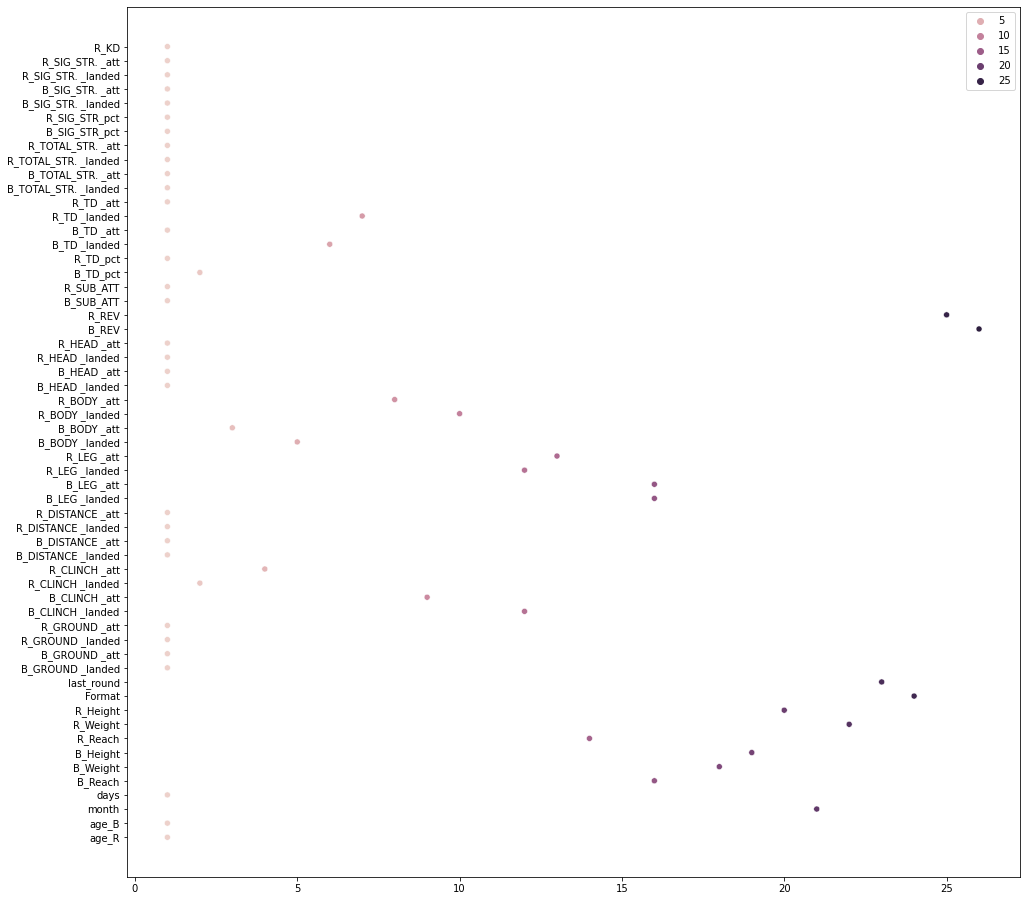

In [291]:
plt.figure(figsize=(12, 8))
sns.scatterplot(y=[col for col in X_train.columns.values], x=brt_ranking, hue=brt_ranking)

In [648]:
selected_features = {}
for i, col in enumerate(X_train.columns):
    if brt_ranking[i] <= 22:
        selected_features[col] = brt_ranking[i]

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 7,
 13: 1,
 14: 6}

In [293]:
features = [k for k in selected_features.keys()]

In [294]:
temp = X_train[features].copy()
temp[target_label] = y_train.copy()
corr = temp.corr(method='pearson')

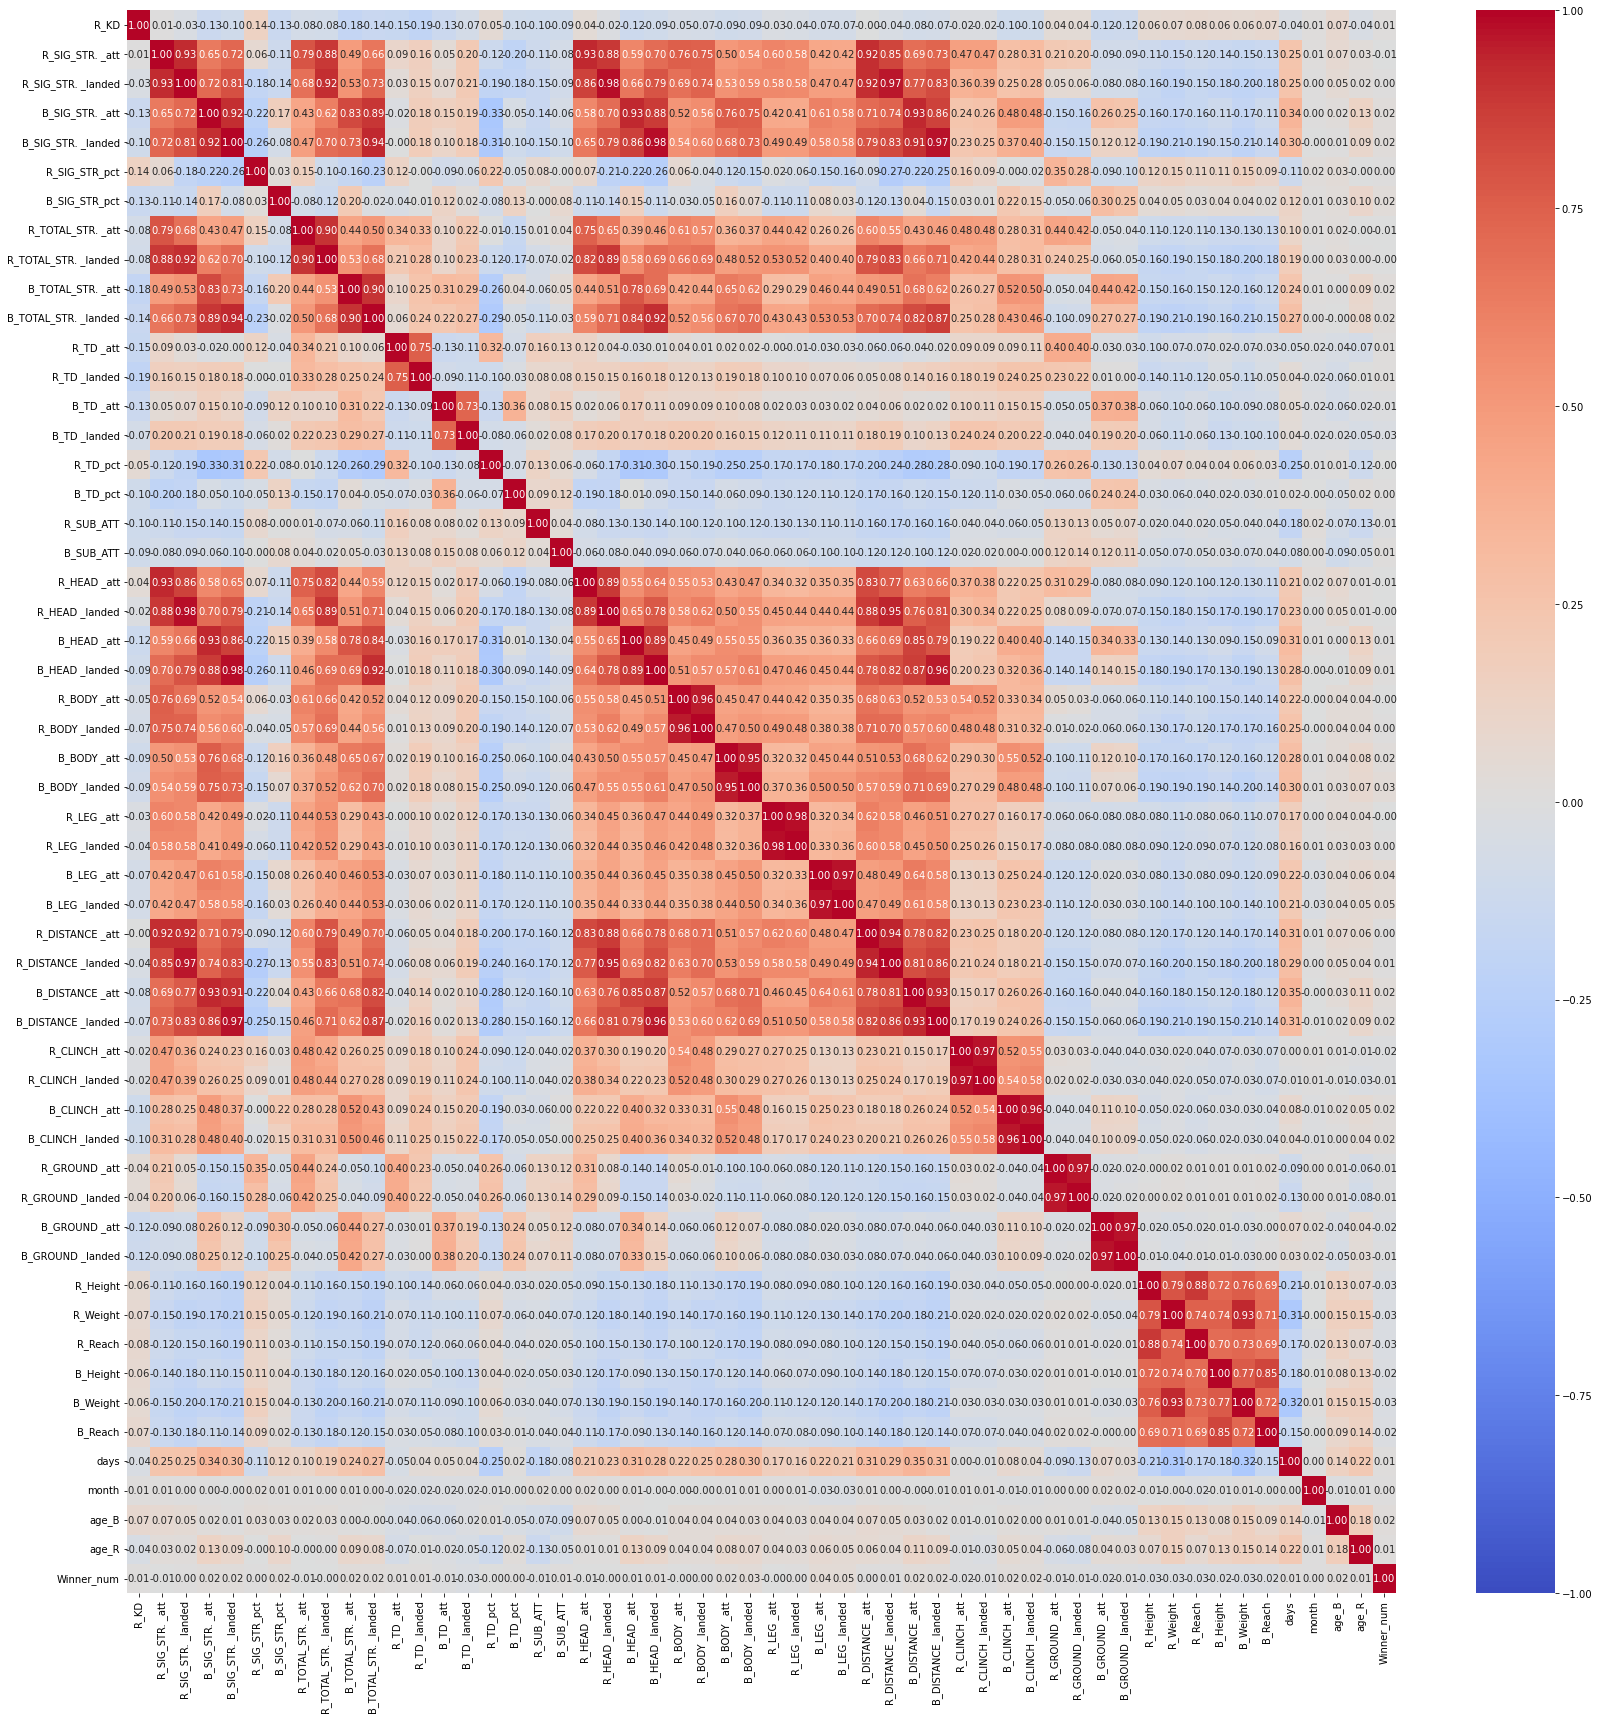

In [295]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [296]:
pca = PCA(n_components=0.9)
pca.fit(X_train[features])
pcs_train = pca.transform(X_train[features])

In [297]:
pdf_train = pd.DataFrame(data = pcs_train)
pdf_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.608327,-0.121206,0.014933,0.018994,0.346808,-0.141840,-0.225883,-0.171867,0.063993,-0.170456,0.074389,-0.095840,0.031475,0.018269,0.039466
1,-0.357711,0.404563,0.225492,0.526018,-0.098165,-0.037175,0.183217,0.236172,0.070886,-0.005164,-0.024419,0.005907,-0.100264,-0.041953,-0.014319
2,-0.529939,-0.168153,0.275294,-0.329200,-0.300640,-0.104963,-0.077539,0.179989,-0.188429,0.018690,-0.030559,0.188494,-0.016193,-0.012613,-0.118734
3,-0.228460,0.739557,0.161143,-0.480270,-0.109648,-0.171123,0.271176,-0.203792,0.017325,-0.129005,-0.101616,-0.135232,0.008895,0.001340,0.123120
4,-0.166838,-0.061755,0.520761,-0.258381,-0.374563,0.235978,0.078371,-0.210061,0.117793,0.205422,0.241140,-0.053858,-0.192399,0.046570,0.111242


In [298]:
pca.explained_variance_*100

array([23.7067697 , 12.98374116, 11.27615085,  9.59500946,  8.75748982,
        4.66411505,  4.02393477,  3.61826961,  3.0987504 ,  2.42342312,
        2.2217606 ,  1.86048394,  1.50954827,  1.32565171,  1.23654092])

<BarContainer object of 15 artists>

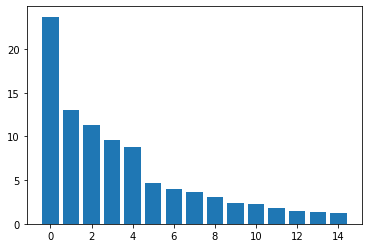

In [299]:
plt.bar(pdf_train.columns, pca.explained_variance_*100)

In [306]:
pcs_test = pca.transform(X_test[features])
pdf_test = pd.DataFrame(data = pcs_test)
X_train = pdf_train.copy()
X_test = pdf_test.copy()
feat = X_train.columns

KeyError: "None of [Index(['R_KD', 'R_SIG_STR. _att', 'R_SIG_STR. _landed', 'B_SIG_STR. _att',\n       'B_SIG_STR. _landed', 'R_SIG_STR_pct', 'B_SIG_STR_pct',\n       'R_TOTAL_STR. _att', 'R_TOTAL_STR. _landed', 'B_TOTAL_STR. _att',\n       'B_TOTAL_STR. _landed', 'R_TD _att', 'R_TD _landed', 'B_TD _att',\n       'B_TD _landed', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',\n       'R_HEAD _att', 'R_HEAD _landed', 'B_HEAD _att', 'B_HEAD _landed',\n       'R_BODY _att', 'R_BODY _landed', 'B_BODY _att', 'B_BODY _landed',\n       'R_LEG _att', 'R_LEG _landed', 'B_LEG _att', 'B_LEG _landed',\n       'R_DISTANCE _att', 'R_DISTANCE _landed', 'B_DISTANCE _att',\n       'B_DISTANCE _landed', 'R_CLINCH _att', 'R_CLINCH _landed',\n       'B_CLINCH _att', 'B_CLINCH _landed', 'R_GROUND _att',\n       'R_GROUND _landed', 'B_GROUND _att', 'B_GROUND _landed', 'R_Height',\n       'R_Weight', 'R_Reach', 'B_Height', 'B_Weight', 'B_Reach', 'days',\n       'month', 'age_B', 'age_R'],\n      dtype='object')] are in the [columns]"

In [308]:
def model_evaluation(model, X_train, y_train, scoring='roc_auc', cv=5):
    cv_results = cross_val_score(model, X_train[feat], y_train, scoring=scoring, cv=cv)
    avg_res = abs(np.mean(cv_results))
    return avg_res

In [311]:
lgbc = LGBMClassifier()
svc = SVC()
etc = ExtraTreesClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier(eval_metric='logloss')

models = [
    lgbc,svc,etc,rfc,xgb
]

In [312]:
results = []
print('WEIGHTED PRECISION SCORES ON TRAINING DATA:\n')
for i, model in enumerate(models):
    result = model_evaluation(model, X_train[feat], y_train, scoring='precision_weighted')
    print(model,':',result)

WEIGHTED PRECISION SCORES ON TRAINING DATA:

LGBMClassifier() : 0.831858324436452
SVC() : 0.8398098569326944
ExtraTreesClassifier() : 0.8239431269752107
RandomForestClassifier() : 0.8240394936667259
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) : 0.824674406710967


In [313]:
results = []
print('ROC AUC SCORES ON TRAINING DATA:\n')
for i, model in enumerate(models):
    result = model_evaluation(model, X_train[feat], y_train)
    print(model,':',result)

ROC AUC SCORES ON TRAINING DATA:

LGBMClassifier() : 0.9025176166227219
SVC() : 0.9090607171158833
ExtraTreesClassifier() : 0.9028713156363153
RandomForestClassifier() : 0.8967624459309607
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) : 0.9018440682440272


In [314]:
test_results = []
print('ACCURACY SCORES ON TEST DATA:\n')
for model in models:
    model.fit(X_train[feat], y_train)
    y_pred = model.predict(X_test[feat])
    test_results.append(precision_score(y_test, y_pred, average='weighted'))
for i, model in enumerate(models):
    print(model, ':', test_results[i])

ACCURACY SCORES ON TEST DATA:

LGBMClassifier() : 0.8215612507183694
SVC() : 0.8423903350557851
ExtraTreesClassifier() : 0.8218220688742378
RandomForestClassifier() : 0.8114928871761888
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 0.816727448126465


In [649]:
hyperparameters = dict(
    C = [4,10],
    kernel = ['poly'],
    degree = [2,3],
    gamma = ['scale'],
    coef0 = [1.02,6],
    random_state = [42],
    class_weight = [{1:1,0:0.57}])

In [317]:
svc = SVC()
gs = GridSearchCV(estimator=svc, param_grid=hyperparameters, verbose=1, cv=5, n_jobs=-1, scoring='precision_weighted')
model1 = gs.fit(X_train[feat], y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [318]:
print(model1.best_estimator_)
print(model1.best_params_)
print(model1.scorer_, abs(model1.best_score_))

SVC(C=4, class_weight={0: 0.57, 1: 1}, coef0=1.02, degree=2, kernel='poly',
    random_state=42)
{'C': 4, 'class_weight': {1: 1, 0: 0.57}, 'coef0': 1.02, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 42}
make_scorer(precision_score, pos_label=None, average=weighted) 0.8487691901857707


In [319]:
y_pred_train = model1.predict(X_train[feat])
y_pred_test = model1.predict(X_test[feat])

print(precision_score(y_train, y_pred_train, average='weighted'))
print(precision_score(y_test, y_pred_test, average='weighted'))

print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred_test))

0.8613267434026638
0.8377206171994146
0.8542672637138293
0.8282476087523043


In [455]:
print(classification_report(y_test, y_pred_test, labels=sorted(model1.classes_, reverse=True)))

              precision    recall  f1-score   support

         1.0       0.72      0.83      0.77       574
         0.0       0.90      0.83      0.86      1083

    accuracy                           0.83      1657
   macro avg       0.81      0.83      0.82      1657
weighted avg       0.84      0.83      0.83      1657



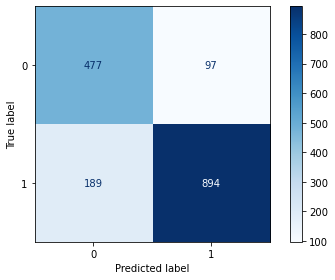

In [456]:
cm = confusion_matrix(y_test, y_pred_test, labels=sorted(model1.classes_, reverse=True))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.tight_layout()
plt.show()

## top n

In [596]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionsProbs = predictionsProbs

    predictionsProbsTopNLowSeverity, predictionsProbsTopNHighSeverity = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionsProbsTopNLowSeverity = list(reversed(sorted(predictionsProbsTopNLowSeverity)))[:int(len(predictionsProbsTopNLowSeverity) * TOP_N / 100)][-1]
    predictionsProbsTopNHighSeverity = list(reversed(sorted(predictionsProbsTopNHighSeverity)))[:int(len(predictionsProbsTopNHighSeverity) * TOP_N / 100)][-1]

    accuracy_Low_Severity = []
    accuracy_High_Severity = []

    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            if predictionsProbs[i][1] > predictionsProbsTopNHighSeverity:
                accuracy_High_Severity.append(int(discreteActualLabels.iloc[i]) == 1)
        else:
            if predictionsProbs[i][0] > predictionsProbsTopNLowSeverity:
                accuracy_Low_Severity.append(int(discreteActualLabels.iloc[i]) == 0)

    accuracy_Low_Severity = round((accuracy_Low_Severity.count(True) * 100) / len(accuracy_Low_Severity), 2)
    accuracy_High_Severity = round((accuracy_High_Severity.count(True) * 100) / len(accuracy_High_Severity), 2)
    return accuracy_Low_Severity, accuracy_High_Severity

+ Accuracy for top 5 percent predictions for Low_Severity: 98.77, High_Severity: 95.06
+ Accuracy for top 10 percent predictions for Low_Severity: 96.95, High_Severity: 92.07
+ Accuracy for top 20 percent predictions for Low_Severity: 97.58, High_Severity: 85.76
+ Accuracy for top 30 percent predictions for Low_Severity: 96.77, High_Severity: 77.62
+ Accuracy for top 40 percent predictions for Low_Severity: 95.61, High_Severity: 75.66


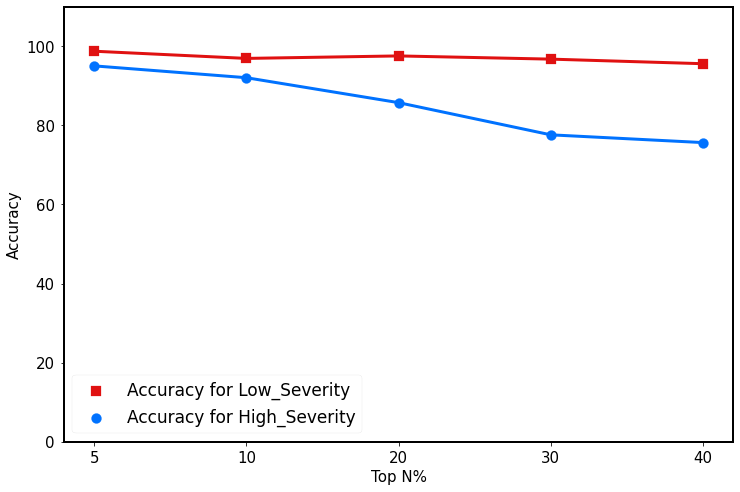

In [645]:

################################## You can change values inside the following list ###########################
topNValues = [5, 10, 20, 30, 40]
##############################################################################################################


Low_Severity, High_Severity = [], []


for topn in topNValues:
    accuracyLow_Severity, accuracyHigh_Severity = calculateClasswiseTopNAccuracy(y_test.astype(int),  xgb.predict_proba(X_test), topn)
    Low_Severity.append(accuracyLow_Severity)
    High_Severity.append(accuracyHigh_Severity)
    
    print("+ Accuracy for top %d percent predictions for Low_Severity: %.2f, High_Severity: %.2f" % (topn, accuracyLow_Severity, accuracyHigh_Severity))
    
# Plot results
x = np.arange(len(Low_Severity))
plt.plot(x, Low_Severity, linewidth = 3, color = '#e01111')
scatterLow_Severity = plt.scatter(x, Low_Severity, marker = 's', s = 100, color = '#e01111')
plt.plot(x, High_Severity, linewidth = 3, color = '#0072ff')
scatterHigh_Severity = plt.scatter(x, High_Severity, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, topNValues, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterLow_Severity, scatterHigh_Severity], ["Accuracy for Low_Severity", "Accuracy for High_Severity"], fontsize = 17)
plt.ylim(0, 110)
plt.show()